## Рекомендательные системы: предсказание оценки

### Пономаревой Алисы ИАД-2

Рассмотрим задачу предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Данные: [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают значения в интервале от 0.5 до 5.0, они записаны в файле *user_ratedmovies.dat* (а также в *user_ratedmovies-timestamps.dat*,  где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

Задача: построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

Метрика качества: будем считать, что пользователю сервиса доступен блок рекомендаций, который может содержать рекомендации не более чем 5 фильмов.
Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов $R^u_{test}$ для этого пользователя рассмотрим 5 рейтингов, поставленные последними по времени, в качестве валидационных $R^u_{val}$ — предпоследние 5 рейтингов. Остальные известные рейтинги этого пользователя будут составлять обучающую выборку $R^u_{train}$.
Для подбора гиперпараметров в рамках данного задания будем использовать валидационную выборку, предварительно обучив модель на обучающей выборке, а для финальной оценки качества — тестовую выборку, предварительно обучив модель на обучающей и валидационной выборках.

**1. (1 балл)** Загрузите данные и сформируйте 3 разреженные матрицы пользователи—фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен.

In [4]:
import numpy as np
import pandas as pd
from scipy import sparse
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [156]:
user_rate = pd.read_csv('user_ratedmovies-timestamps.dat', sep='\t')

In [157]:
user_rate.head()

,userID,movieID,rating,timestamp
0,75,3,1.0,1162160236000
1,75,32,4.5,1162160624000
2,75,110,4.0,1162161008000
3,75,160,2.0,1162160212000
4,75,163,4.0,1162160970000


In [158]:
# YOUR CODE IS HERE

In [159]:
uid = user_rate['userID'].unique()
fid = user_rate['movieID'].unique()
 
z_id = lambda uid: dict(zip(uid,np.arange(uid.shape[0])))

In [160]:
users_dict = z_id(uid)
movies_dict = z_id(fid)

In [161]:
user_rate['userID'] = user_rate['userID'].map(users_dict)
user_rate['movieID'] = user_rate['movieID'].map(movies_dict)
user_rate.sort_values(['userID','timestamp'],ascending = [True, False],inplace = True)

In [162]:
test=pd.DataFrame(columns=list(user_rate.columns) )
val=pd.DataFrame(columns=list(user_rate.columns))
train=pd.DataFrame(columns=list(user_rate.columns))

In [163]:
for user in np.unique(user_rate.userID):
    current = user_rate[user_rate.userID == user]
    
    if len(current.movieID) > 5:
        test = test.append(current[:5])
    if len(current.movieID) - 5 > 5:
        val = val.append(current[5:10])
    if len(current.movieID) - 10 > 0:
        train = train.append(current[10:])

In [164]:
train.head()

,userID,movieID,rating,timestamp
4,0,4,4.0,1162160970000
27,0,27,4.0,1162160965000
36,0,36,3.0,1162160956000
17,0,17,4.5,1162160936000
16,0,16,3.5,1162160932000


In [165]:
train_mat = sparse.csr_matrix((train['rating'],(train['userID'],train['movieID'])),(uid.shape[0],fid.shape[0]))

In [166]:
val_mat = sparse.csr_matrix((val['rating'],(val['userID'],val['movieID'])),(uid.shape[0],fid.shape[0]))

In [167]:
test_mat = sparse.csr_matrix((test['rating'],(test['userID'],test['movieID'])),(uid.shape[0],fid.shape[0]))

In [168]:
train_mat.shape

(2113, 10109)

In [169]:
val_mat.shape

(2113, 10109)

In [170]:
test_mat.shape

(2113, 10109)

Качество рекомендаций: будем использовать метрики RMSE@k и nDCG@k для $k=5$, описанные ниже.

#### RMSE@k

Поскольку нас интересуют лишь фильмы, попавшие в блок рекомендаций, качество работы модели можно оценивать при помощи RMSE на $k$ фильмах с наибольшим предсказанным рейтингом, где $k$ — размер блока рекомендаций. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}$. Тогда RMSE@k:

$$ \text{RMSE@k}(u) = \sqrt{ \frac{1}{k} \sum_{i=1}^k (r_{u(i)} - \hat{r}_{u(i)})^2 },$$
$$ \text{RMSE@k} = \frac{1}{|U|} \sum_{u \in U} \text{RMSE@k}(u),$$
где $U$ — множество пользователей. При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

#### nDCG@k

Также можно использовать метрику качества ранжирования. Для этого для каждого пользователя $u$ предскажем оценку для всех фильмов из $R^u_{test}$ и отсортируем эти фильмы по убыванию предсказанного рейтинга. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}.$

Тогда nDCG@k :

$$\text{DCG@k}(u) = \sum_{i=1}^k g(r_{u(i)}) d(i),$$
$$\text{nDCG@k}(u) = \frac{\text{DCG@k}(u)}{\max \text{DCG@k}(u)},$$
$$\text{nDCG@k} = \frac{1}{|U|} \sum_{u \in U} \text{nDCG@k}(u),$$
где $g(r)$ — функция полезности фильма, а  $d(i)$ — штраф за позицию.

Положим $g(r) = 2^r-1, \, d(i) = \frac{1}{\log_2 (i+1)}.$ При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

**2. (2 балла)** Реализуйте функции rmse_score и ndcg_score, вычисляющие значения описанных выше метрик. Каждая из функций в качестве параметров должна принимать:
 * y_true — матрицу тестовых рейтингов (сформированную аналогично матрице тестовых рейтингов из предыдущего пункта; функция должна корректно работать и для разреженных, и для плотных матриц);
 * y_predicted — матрицу предсказаний модели в аналогичном формате (функция должна корректно работать и для разреженных, и для плотных матриц);
 * k — параметр $k$ в определениях метрик.

In [200]:
def rmse_score(y_true, y_predicted, k=5):
    if type(y_true) == sparse.csr.csr_matrix:
        y_true_ = y_true.toarray()
    else:
        y_true_ = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted_ = y_predicted.toarray()
    else:
        y_predicted_ = y_predicted

    # YOUR CODE IS HERE
    rmse = 0
    for i, u in enumerate(y_predicted_):
        arg_sort_arr = np.argsort(-u)
        rmse += np.sqrt((1/k)*np.sum((u[arg_sort_arr[:k]] - y_true_[i, arg_sort_arr[:k]])**2))
    return rmse/y_true.shape[0]

def ndcg_score(y_true, y_predicted, k=5):
    if type(y_true) == sparse.csr.csr_matrix:
        y_true_ = y_true.toarray()
    else:
        y_true_ = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted_ = y_predicted.toarray()
    else:
        y_predicted_ = y_predicted

    # YOUR CODE IS HERE
    ndcg = []
    d_i= 1/np.log2(np.array(range(1,k+1))+2)
    for i, u in enumerate(y_true_):
        arg_sort_arr = np.argsort(-y_predicted_[i])
        dcg = sum((2**u[arg_sort_arr][:k] - 1)*d_i)
        arg_sort_arr = np.argsort(-y_true_[i])
        maxdcg = sum((2**u[arg_sort_arr][:k] - 1)*d_i)
        ndcg.append(dcg/maxdcg)
    return sum(ndcg)/y_true.shape[0]

**3. (1 балл)** Постройте рекомендации на основе **most popular** метода, при котором предсказанный рейтинг для некоторого фильма $i$ одинаков для всех пользователей и совпадает со средним значением рейтинга по всем пользователям, оценившим этот фильм, и вычислите значения метрик RMSE@5 и nDCG@5 для тестовой матрицы из п. 1.

In [214]:
most_pop = np.zeros((test_mat.shape[0], test_mat.shape[1]))

# YOUR CODE IS HERE

In [208]:
test_mat.shape[0]

2113

In [209]:
test_mat.shape[1]

10109

In [213]:
all_mat = train_mat+val_mat

In [215]:
for i in range(most_pop.shape[1]):
    if (all_mat[:, i].count_nonzero()!=0):
        most_pop[:, i] = sum(all_mat[:, i].toarray())[0]/(all_mat[:, i].count_nonzero())
    else:
        most_pop[:, i] = 0

In [216]:
most_pop

array([[2.8685259 , 4.00870322, 3.84346754, ..., 1.5       , 2.5       ,
        3.        ],
       [2.8685259 , 4.00870322, 3.84346754, ..., 1.5       , 2.5       ,
        3.        ],
       [2.8685259 , 4.00870322, 3.84346754, ..., 1.5       , 2.5       ,
        3.        ],
       ...,
       [2.8685259 , 4.00870322, 3.84346754, ..., 1.5       , 2.5       ,
        3.        ],
       [2.8685259 , 4.00870322, 3.84346754, ..., 1.5       , 2.5       ,
        3.        ],
       [2.8685259 , 4.00870322, 3.84346754, ..., 1.5       , 2.5       ,
        3.        ]])

In [217]:
rmse_score(test_mat, most_pop, k=5)

4.999544923963958

In [218]:
ndcg_score(test_mat, most_pop, k=5)

0.00012281961700207926

**4. (1 балл)** Реализуйте построение рекомендаций путём разложения матрицы рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (в предположении, что неизвестные рейтинги заменяются на нули) и последующего её восстановления и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения)

In [195]:
from sklearn.decomposition import TruncatedSVD

In [196]:
#из семинара
ranks = np.arange(10, 110, 10)

rmse_vals = []
ndcge_vals = []

for r in np.arange(10, 110, 10):
    print('rank', r)
    # YOUR CODE IS HERE
    svd = TruncatedSVD(n_components=r, random_state=42)
    t = svd.fit_transform(train_mat)
    pred = svd.inverse_transform(t)
    cur_rmse = rmse_score(val_mat, pred)
    cur_ndcg = ndcg_score(val_mat, pred)
    rmse_vals.append(cur_rmse)
    ndcge_vals.append(cur_ndcg)
    print('rmse', cur_rmse)
    print('ndcg', cur_ndcg)

rank 10
rmse 3.4245147872730097
ndcg 0.011057531536708697
rank 20
rmse 3.732013889757425
ndcg 0.010179044698457478
rank 30
rmse 3.873299826503154
ndcg 0.0085385813707049
rank 40
rmse 3.9892714618536673
ndcg 0.008480099730905407
rank 50
rmse 4.087322815154796
ndcg 0.006456700937414107
rank 60
rmse 4.158692344791574
ndcg 0.005873053073943309
rank 70
rmse 4.207346279519091
ndcg 0.0053308191103538715
rank 80
rmse 4.26311333275177
ndcg 0.004771201228575951
rank 90
rmse 4.31110320855628
ndcg 0.004142404905779462
rank 100
rmse 4.347709972976367
ndcg 0.003624806427427621


Text(0.5,0,'rank')

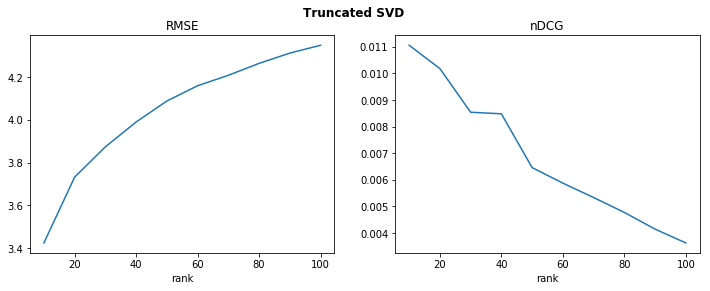

In [197]:
#из семинара
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
args = np.arange(10, 110, 10)

fig.suptitle('Truncated SVD', fontweight='bold')
ax1.plot(args, rmse_vals)
ax2.plot(args, ndcge_vals)
ax1.set_title('RMSE')
ax2.set_title('nDCG')
ax1.set_xlabel('rank')
ax2.set_xlabel('rank')

**5. (3 балла)** Постройте рекомендации на основе user-based коллаборативной фильтрации. 
Предсказание модели $\hat{r}_{ui}$ вычисляйте по следующей формуле:
$$\hat{r}_{ui} = \bar{r}_{u} + \frac{\sum_{v \in U(u)} w_{uv} (r_{vi} - \bar{r}_v)}{\sum_{v \in U(u)} w_{uv}},$$
где $\bar{r}_u$ — средний ретинг пользователя $u$, $w_{uv}$ — мера сходства пользователей $u$ и $v$, $U(u) = \{ v \in U \, | \, w_{uv} > \alpha\}$ — коллаборация пользователя $u$. 

Значение параметра $\alpha$ возьмите равным 0.9.

Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке.

In [ ]:
from tqdm import tqdm, tqdm_notebook
import sklearn.preprocessing as pp

In [293]:
def pirson(u,v):
    inds = list(set(u.nonzero()[0])& set(v.nonzero()[0]))
    if len(inds)>0:
        if len(inds)!=1:
            shum = np.random.random(len(inds))/10000
            result = np.corrcoef(u[inds]+shum,v[inds]+shum)[0,1]
        else:
            result = -1
    else:
        result = -1
    return result

In [306]:
def user_based(train, alpha = 0.9):
    data = train.toarray()
    result = []
    for i,r_u in enumerate(data):
        if (i%(uid.shape[0]//100)==0):
            print(i//(uid.shape[0]//100),"%")
        temp = []
        ws = []
        for j,r_v in enumerate(data):
            if (i!=j):
                w_uv = pirson(r_u,r_v)
                if (w_uv>alpha):
                    ws.append(w_uv)
                    temp.append(r_v-np.mean(r_v))
        ws = np.array(ws)
        temp = np.array(temp)
        res = np.zeros((data.shape[1],))+np.mean(r_u)
        if (sum(ws) != 0):
            res += sum(ws.reshape(-1,1)*temp)/sum(ws)
        result.append(res)
    return result

In [307]:
kol_fil = user_based(train_mat)

0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
100 %


In [309]:
kol_fil_mat = np.array(kol_fil)

In [310]:
kol_fil_mat.shape

(2113, 10109)

In [312]:
rmse_score(test_mat, kol_fil_mat , k=5)

1.2200688479229762

In [313]:
ndcg_score(test_mat, kol_fil_mat, k=5)

0.011703849422385166

**6. (1 балл)** Какой метод оказался лучше по каким метрикам? Почему?

Метод most_popalr по метрике ndcg оказался лучше : ndcg score = 0.00012281961700207926 <br>
Метрика rmse показала науилучший результат 1.22 в методе user_based


**7. (1 балл)** Приведите достоинства и недостатки используемых метрик. Какие еще метрики можно было бы использовать для решения задачи? Приведите примеры других постановок задачи, как в этом случае можно было бы оценить качество?

Недостатки user_based метода в том, что у меры сходства есть недостатки из-за формулы <br>
Метрика rmse слишком ошибается